In [1]:
import pandas as pd
import datetime
import sqlite3
from dateutil.relativedelta import relativedelta

path = "../findajob.db"
conn =  sqlite3.connect(path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = cursor.fetchall()

# print("overview of tables:")
# for table in tables:
#     print(table)
    
job_types = "SELECT * FROM job_types ORDER BY type_name"
df_job_types = pd.read_sql(job_types, conn)

result_types = "SELECT * FROM results"
df_result_types = pd.read_sql(result_types, conn)

# Load openings
openings = "SELECT * FROM openings"
df_openings = pd.read_sql(openings, conn)

# Transform openings dates to format %Y-%m-%d %H:%M:%S+00:00
rows = []
for row in df_openings['application_date']:
    row = pd.to_datetime(row, errors='coerce').strftime('%Y-%m-%d %H:%M:%S+00:00')
    row = pd.to_datetime(row)
    rows.append(row)

df_openings['application_date'] = rows

def monthly_stats(df: pd.DataFrame, heading: str):
    
    res = {}    
    # pending jobs
    df_pending_jobs = df[df['result'] == 1]
    count_pending_jobs = df_pending_jobs['id'].count()
    # print(f"I am wating for {count_pending_jobs} companies to respond")
    # res = {
    #     "count_pending_jobs": count_pending_jobs
    # }

    # ghosted jobs
    df_ghosted_jobs = df[df['result'] == 5]
    count_ghosted_jobs = df_ghosted_jobs['id'].count()
    # print(f"I was ghosted by {count_ghosted_jobs} companies")
    res['count_ghosted_jobs'] = count_ghosted_jobs

    # rejected jobs
    df_rejected_jobs = df[df['result'] == 3]
    count_rejected_jobs = df_rejected_jobs['id'].count()
    # print(f"I was rejected by {count_rejected_jobs} companies")
    res['count_rejected_jobs'] = count_rejected_jobs

    # interviewed jobs
    df_interview_jobs = df[df['result'] == 2]
    count_interviewed_jobs = df_interview_jobs['id'].count()
    # print(f"I had {count_interviewed_jobs} interviews")
    res['count_interviewed_jobs'] = count_interviewed_jobs


    # rates
    count_applications = sum([count_pending_jobs, count_ghosted_jobs, count_rejected_jobs, count_interviewed_jobs])
    # print(f"I applied for {count_applications} jobs in total")
    ghost_rate = len(df_ghosted_jobs)/count_applications*100
    # print(f"My ghost rate is: {round(ghost_rate)}%")
    res['ghost_rate'] = round(ghost_rate)
    

    interview_rate = len(df_interview_jobs)/count_applications*100
    # print(f"My interview rate is: {round(interview_rate)}%")
    res['interview_rate'] = round(interview_rate)
    
    reject_rate = count_rejected_jobs/count_applications*100
    # print(f"My fail rate is: {round(reject_rate)}%")
    res['reject_rate'] = round(reject_rate)
    res['count_applications'] = count_applications
    
    # print("-------------")
    
    return res

def convert_in_utc_timestamp(d: datetime.datetime) -> pd.Timestamp:
    return pd.to_datetime(datetime.datetime(d.year, d.month, d.day, 0, 0, 0, tzinfo=datetime.timezone.utc))


current_date = datetime.datetime.now()
df_monthly = pd.DataFrame()
for end in range(6):
    start = end+1
    
    # find dates
    begin = current_date - relativedelta(months=start)
    stop = current_date - relativedelta(months=end)
    
    # convert to utc
    begin_utc = convert_in_utc_timestamp(begin)
    stop_utc = convert_in_utc_timestamp(stop)
     
    stats = monthly_stats(df_openings[(df_openings['application_date'] > begin_utc) & (df_openings['application_date'] < stop_utc) ], heading=str(start))
    stats['number_of_month_ago'] = start
    stats['time_of_month_ago'] = begin.month
    row = pd.DataFrame([stats])
    df_monthly = pd.concat([df_monthly, row])
    
print(df_monthly)   
assert (df_monthly['number_of_month_ago'] > 0).all(), "Some values in 'number_of_month_ago' are not greater than 0"
assert (df_monthly['time_of_month_ago'] > 0).all(), "Some values in 'time_of_month_ago' are not greater than 0"

conn.close()

   count_ghosted_jobs  count_rejected_jobs  count_interviewed_jobs  \
0                   2                    2                       0   
0                  29                   11                       0   
0                   8                    3                       0   
0                  16                   15                       2   
0                  25                   11                       0   
0                  29                   12                       1   

   ghost_rate  interview_rate  reject_rate  count_applications  \
0          25               0           25                   8   
0          71               0           27                  41   
0          73               0           27                  11   
0          48               6           45                  33   
0          69               0           31                  36   
0          69               2           29                  42   

   number_of_month_ago  time_of_month_ago  
0 

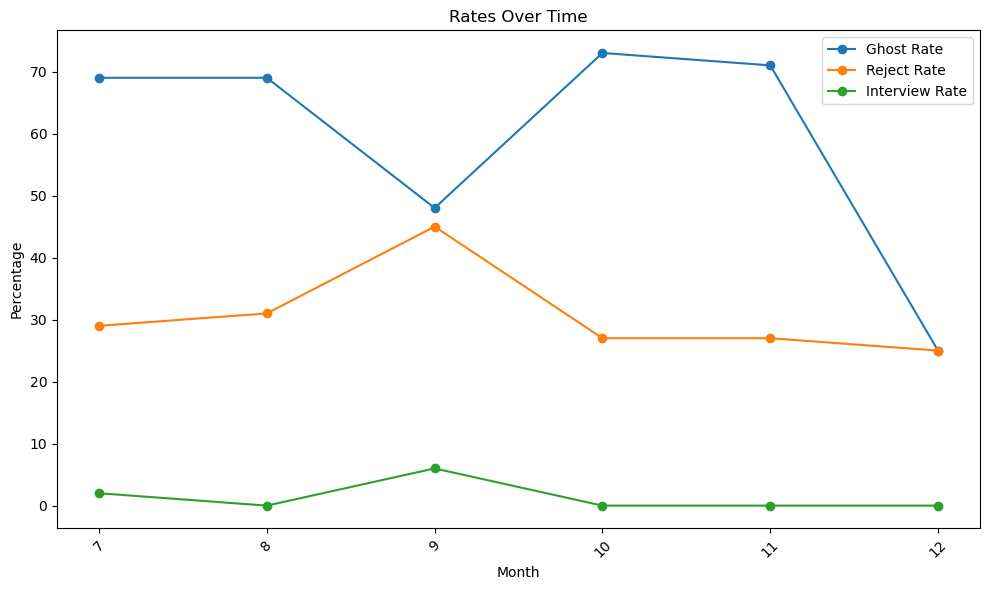

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Add a 'ghost_rate' column
# Group by time periods (optional, if not daily)
# df['week'] = df['application_date'].dt.to_period('W')
# weekly_data = df.groupby('week').mean()

# Plot the ghost rate over time
plt.figure(figsize=(10, 6))
plt.plot(df_monthly['time_of_month_ago'], df_monthly['ghost_rate'], marker='o', label='Ghost Rate')
plt.plot(df_monthly['time_of_month_ago'], df_monthly['reject_rate'], marker='o', label='Reject Rate')
plt.plot(df_monthly['time_of_month_ago'], df_monthly['interview_rate'], marker='o', label='Interview Rate')

plt.title('Rates Over Time')
plt.xlabel('Month')
plt.ylabel('Percentage')
# plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

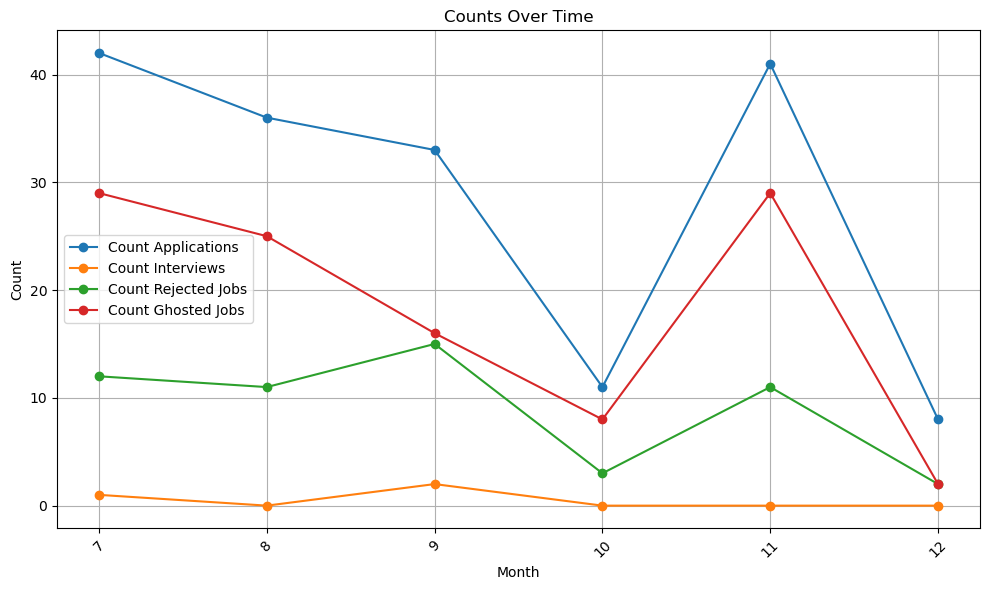

I applied to 171 jobs
On averge I applied to 28 jobs per month
On averge I scored 0.5 interviews per month
On averge I got 9 rejections per month
On averge I was ghosted by 18 jobs per month


In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df_monthly['time_of_month_ago'], df_monthly['count_applications'], marker='o', label='Count Applications')
plt.plot(df_monthly['time_of_month_ago'], df_monthly['count_interviewed_jobs'], marker='o', label='Count Interviews')
plt.plot(df_monthly['time_of_month_ago'], df_monthly['count_rejected_jobs'], marker='o', label='Count Rejected Jobs')
plt.plot(df_monthly['time_of_month_ago'], df_monthly['count_ghosted_jobs'], marker='o', label='Count Ghosted Jobs')

plt.title('Counts Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

avg_count_application_per_month =round(df_monthly['count_applications'].mean())
avg_count_interviews_per_month = round(df_monthly['count_interviewed_jobs'].mean(), 2)
avg_count_rejected_per_month =round(df_monthly['count_rejected_jobs'].mean())
avg_count_ghosted_per_month =round(df_monthly['count_ghosted_jobs'].mean())
print(f'I applied to {round(df_monthly['count_applications'].sum())} jobs')
print(f'On averge I applied to {avg_count_application_per_month} jobs per month')
print(f'On averge I scored {avg_count_interviews_per_month} interviews per month')
print(f'On averge I got {avg_count_rejected_per_month} rejections per month')
print(f'On averge I was ghosted by {avg_count_ghosted_per_month} jobs per month')